In [48]:
#Importing all the required libraries.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import folium 
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

In [49]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_a49e523c14914d999c35b5075206304b = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='5R2_GYdB-9FP_3PvshGd4N-dnZty3AF6H8i4CWNTBKIs',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_a49e523c14914d999c35b5075206304b.get_object(Bucket='capstone-donotdelete-pr-2frj5p6so7igwi',Key='complete_dataset.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)


In [50]:
df.head(10)

,Unnamed: 0,Borough,Neighborhoods,Latitude,Longitude,Population,City,AverageIncome
0,0,Central,Cantonment area,12.972442,77.580643,866377,Bangalore,18944.099792
1,1,Central,Domlur,12.960992,77.638726,743186,Bangalore,56837.022198
2,2,Central,Indiranagar,12.971891,77.641151,474289,Bangalore,41991.817435
3,3,Central,Jeevanbheemanagar,12.962900,77.659500,527874,Bangalore,6667.447632
4,4,Central,Malleswaram,13.003100,77.564300,893629,Bangalore,53270.063892
5,5,Central,Pete area,12.962700,77.575800,730999,Bangalore,50712.430215
6,6,Central,Rajajinagar,12.990100,77.552500,981362,Bangalore,60967.535874
7,7,Central,Sadashivanagar,13.006800,77.581300,662625,Bangalore,59943.541564
8,8,Central,Seshadripuram,12.993500,77.578700,396862,Bangalore,58407.090338
9,9,Central,Shivajinagar,12.985700,77.605700,77836,Bangalore,55850.962099


In [51]:
df.drop('Unnamed: 0',axis=1,inplace=True)

Creating 'Population' and 'Income' dataframe from the main dataframe

In [52]:
bangalore_population = pd.DataFrame(df[['Borough','Neighborhoods','Population']])

In [53]:
bangalore_population.head()

,Borough,Neighborhoods,Population
0,Central,Cantonment area,866377
1,Central,Domlur,743186
2,Central,Indiranagar,474289
3,Central,Jeevanbheemanagar,527874
4,Central,Malleswaram,893629


In [54]:
#bangalore_population.to_csv('data/population_dataset.csv')

In [55]:
bangalore_income = pd.DataFrame(df[['Borough','Neighborhoods','AverageIncome']])

In [56]:
bangalore_income.head()

,Borough,Neighborhoods,AverageIncome
0,Central,Cantonment area,18944.099792
1,Central,Domlur,56837.022198
2,Central,Indiranagar,41991.817435
3,Central,Jeevanbheemanagar,6667.447632
4,Central,Malleswaram,53270.063892


In [57]:
#bangalore_income.to_csv('data/income_dataset.csv')

In [58]:
bangalore_latitude = df['Latitude'].mean()
bangalore_longitude = df['Longitude'].mean()
print("Latitude and Longitude of Bangalore are : ",bangalore_latitude,bangalore_longitude)

Latitude and Longitude of Bangalore are :  12.962339620312497 77.60175294687502


In [59]:
CLIENT_ID = 'UWKUAGJUAHZGQ04D10JGEJA1QMW5OLV2MB0URNDIJOTPI0QC' # your Foursquare ID
CLIENT_SECRET = 'PNVUJYW3JCFNNTYM00ZCZYD3K1MWXRL1AW4AL14X34FSJFMZ' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UWKUAGJUAHZGQ04D10JGEJA1QMW5OLV2MB0URNDIJOTPI0QC
CLIENT_SECRET:PNVUJYW3JCFNNTYM00ZCZYD3K1MWXRL1AW4AL14X34FSJFMZ


In [60]:
unique_boroughs_of_bangalore = df['Borough'].unique().tolist()

In [61]:
unique_boroughs_of_bangalore

['Central',
 'Eastern',
 'NorthEastern',
 'Northern',
 'SouthEastern',
 'Southern',
 'SouthernSuburbs',
 'Western']

In [62]:
borough_colors ={}
for i in unique_boroughs_of_bangalore:
    borough_colors[i] = '#%02X%02X%02X' % tuple(np.random.choice(range(256),size=3))

In [63]:
borough_colors

{'Central': '#009EBE',
 'Eastern': '#61731E',
 'NorthEastern': '#07769F',
 'Northern': '#869026',
 'SouthEastern': '#DF17F5',
 'Southern': '#53ECB2',
 'SouthernSuburbs': '#B5E449',
 'Western': '#FD699A'}

In [64]:
bangalore_map = folium.Map(location=[bangalore_latitude,bangalore_longitude],zoom_start=12,control_scale=True)

In [65]:
for lat,lng,boro,nei in zip(df['Latitude'],
                           df['Longitude'],
                           df['Borough'],
                           df['Neighborhoods']):
    label_text = boro + ' - ' + nei
    label = folium.Popup(label_text,parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    tooltip = label_text,
    radius = 4,
    popup = label,
    color=borough_colors[boro],
    fill=True,
    fill_color = borough_colors[boro],
    fill_opacity=0.7).add_to(bangalore_map)

In [66]:
bangalore_map

# Exploring bangalore Neighborhoods using FourSquare API

In [67]:
def getNearbyVenues(names, boro, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, boro, lat, lng in zip(names, boro, latitudes, longitudes):
        print("Fetching venues for : ",name)            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            boro,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                             'Borough',
                             'Neighborhood Latitude', 
                             'Neighborhood Longitude', 
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    
    return(nearby_venues)

In [68]:
bangalore_venues = getNearbyVenues(names=df['Neighborhoods'],latitudes=df['Latitude'],longitudes=df['Longitude'],boro=df['Borough'])

Fetching venues for :  Cantonment area
Fetching venues for :  Domlur
Fetching venues for :  Indiranagar
Fetching venues for :  Jeevanbheemanagar
Fetching venues for :  Malleswaram
Fetching venues for :  Pete area
Fetching venues for :  Rajajinagar
Fetching venues for :  Sadashivanagar
Fetching venues for :  Seshadripuram
Fetching venues for :  Shivajinagar
Fetching venues for :  Ulsoor
Fetching venues for :  Vasanth Nagar
Fetching venues for :  Bellandur
Fetching venues for :  CV Raman Nagar
Fetching venues for :  Hoodi
Fetching venues for :  Krishnarajapuram
Fetching venues for :  Mahadevapura
Fetching venues for :  Marathahalli
Fetching venues for :  Varthur
Fetching venues for :  Whitefield
Fetching venues for :  Banaswadi
Fetching venues for :  HBR Layout
Fetching venues for :  Horamavu
Fetching venues for :  Kammanahalli
Fetching venues for :  Lingarajapuram
Fetching venues for :  Ramamurthy Nagar
Fetching venues for :  Hebbal
Fetching venues for :  Jalahalli
Fetching venues for :

In [69]:
print("Total number of venues found in Bangalore are : ",bangalore_venues.shape[0])

Total number of venues found in Bangalore are :  608


In [70]:
bangalore_venues.head(5)

,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Cantonment area,Central,12.972442,77.580643,Hotel Fishland,12.975569,77.578592,Seafood Restaurant
1,Cantonment area,Central,12.972442,77.580643,Adigas Hotel,12.973554,77.579161,Restaurant
2,Cantonment area,Central,12.972442,77.580643,Sapna Book House,12.976355,77.578461,Bookstore
3,Cantonment area,Central,12.972442,77.580643,Vasudev Adigas,12.973707,77.579257,Indian Restaurant
4,Cantonment area,Central,12.972442,77.580643,Kamat Yatrinivas,12.975985,77.578125,Indian Restaurant


In [71]:
bangalore_venues.groupby('Venue Category').count()['Neighborhood'].sort_values(ascending=False).head(10)

Venue Category
Indian Restaurant       111
Café                     30
Fast Food Restaurant     30
Bakery                   25
Department Store         22
Ice Cream Shop           19
Coffee Shop              18
Pizza Place              18
Chinese Restaurant       16
Clothing Store           12
Name: Neighborhood, dtype: int64

In [72]:
print("Total number of unique categories in bangalore are : ",len(bangalore_venues['Venue Category'].unique()))

Total number of unique categories in bangalore are :  131


### Getting number of venues per neighborhood

In [73]:
individual_bangalore_venue_count = bangalore_venues.groupby(['Borough','Neighborhood'])['Borough'].count().to_frame()

In [74]:
individual_bangalore_venue_count

Borough
Borough         Neighborhood                 
Central         Cantonment area             6
                Domlur                     10
                Indiranagar                65
                Jeevanbheemanagar           7
                Malleswaram                 6
                Pete area                   3
                Rajajinagar                15
                Sadashivanagar             21
                Seshadripuram               7
                Shivajinagar               11
                Ulsoor                      4
                Vasanth Nagar              30
Eastern         Bellandur                  28
                CV Raman Nagar              6
                Hoodi                       4
                Krishnarajapuram            2
                Mahadevapura                5
                Marathahalli                7
                Varthur                     1
                Whitefield                  8
NorthEastern    Banaswadi                   8
                HBR Layout                  5
                Horamavu                    3
                Kammanahalli               11
                Lingarajapuram              1
                Ramamurthy Nagar            6
Northern        Hebbal                      7
                Jalahalli                   3
                Mathikere                  10
                R. T. Nagar                 6
...                                       ...
                Yeshwanthpur                8
SouthEastern    BTM Layout                 36
                Bommanahalli                6
                Bommasandra                 1
                Electronic City             5
                HSR Layout                 10
                Koramangala                 6
                Madiwala                   21
Southern        Banashankari               10
                Basavanagudi               11
                Girinagar                   3
                J. P. Nagar                25
                Jayanagar                  14
                Kumaraswamy Layout         12
                Padmanabhanagar             5
                Uttarahalli                13
SouthernSuburbs Anjanapura                  1
                Arekere                    26
                Begur                       4
                Gottigere                   6
                Hulimavu                    5
                Kothnur                     5
Western         Basaveshwaranagar          21
                Kamakshipalya               3
                Kengeri                     6
                Mahalakshmi Layout         12
                Nagarbhavi                  7
                Nayandahalli                3
                Rajarajeshwari Nagar        6
                Vijayanagar                 4

[62 rows x 1 columns]

In [75]:
individual_bangalore_venue_count.rename(columns={'Borough':'NumberOfVenues'},inplace=True)

In [76]:
individual_bangalore_venue_count.reset_index(inplace=True)

In [77]:
individual_bangalore_venue_count

,Borough,Neighborhood,NumberOfVenues
0,Central,Cantonment area,6
1,Central,Domlur,10
2,Central,Indiranagar,65
3,Central,Jeevanbheemanagar,7
4,Central,Malleswaram,6
5,Central,Pete area,3
6,Central,Rajajinagar,15
7,Central,Sadashivanagar,21
8,Central,Seshadripuram,7
9,Central,Shivajinagar,11


[Text(0, 0, 'Cantonment area'),
 Text(0, 0, 'Domlur'),
 Text(0, 0, 'Indiranagar'),
 Text(0, 0, 'Jeevanbheemanagar'),
 Text(0, 0, 'Malleswaram'),
 Text(0, 0, 'Pete area'),
 Text(0, 0, 'Rajajinagar'),
 Text(0, 0, 'Sadashivanagar'),
 Text(0, 0, 'Seshadripuram'),
 Text(0, 0, 'Shivajinagar'),
 Text(0, 0, 'Ulsoor'),
 Text(0, 0, 'Vasanth Nagar'),
 Text(0, 0, 'Bellandur'),
 Text(0, 0, 'CV Raman Nagar'),
 Text(0, 0, 'Hoodi'),
 Text(0, 0, 'Krishnarajapuram'),
 Text(0, 0, 'Mahadevapura'),
 Text(0, 0, 'Marathahalli'),
 Text(0, 0, 'Varthur'),
 Text(0, 0, 'Whitefield'),
 Text(0, 0, 'Banaswadi'),
 Text(0, 0, 'HBR Layout'),
 Text(0, 0, 'Horamavu'),
 Text(0, 0, 'Kammanahalli'),
 Text(0, 0, 'Lingarajapuram'),
 Text(0, 0, 'Ramamurthy Nagar'),
 Text(0, 0, 'Hebbal'),
 Text(0, 0, 'Jalahalli'),
 Text(0, 0, 'Mathikere'),
 Text(0, 0, 'R. T. Nagar'),
 Text(0, 0, 'Vidyaranyapura'),
 Text(0, 0, 'Yelahanka'),
 Text(0, 0, 'Yeshwanthpur'),
 Text(0, 0, 'BTM Layout'),
 Text(0, 0, 'Bommanahalli'),
 Text(0, 0, 'Bommasan

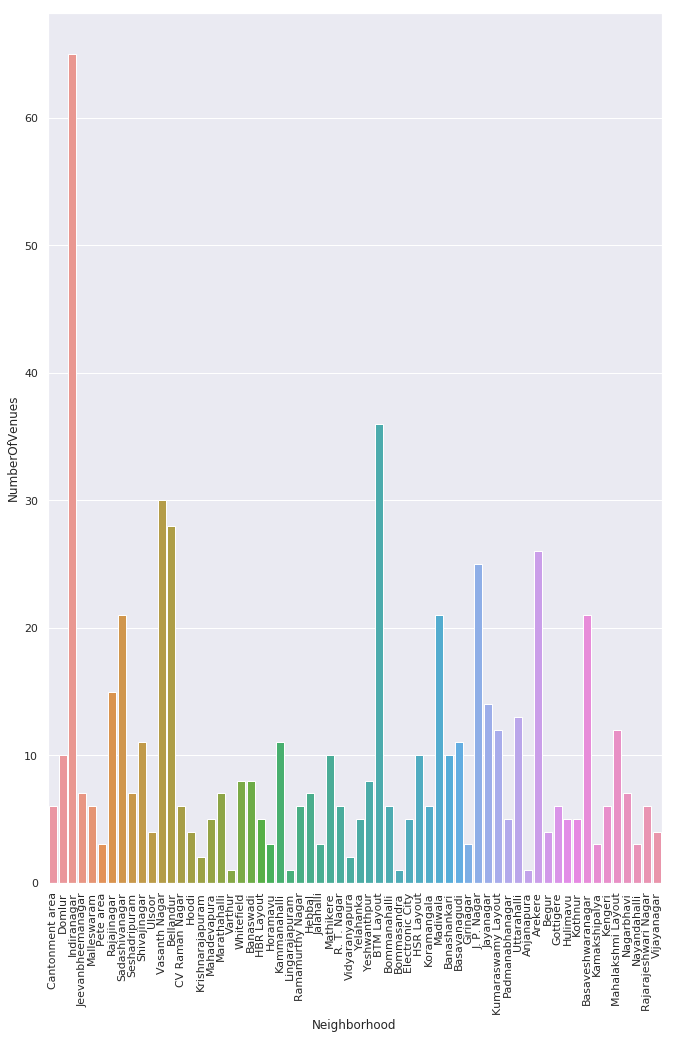

In [78]:
sns.set(rc={'figure.figsize':(11,16)})
plot = sns.barplot(x='Neighborhood',y='NumberOfVenues',data=individual_bangalore_venue_count)
plot.set_xticklabels(individual_bangalore_venue_count['Neighborhood'],rotation=90)

#### From the above graph we can see that indiranagar has most number of venues.

## Exploring Whitefield venues

In [79]:
bangalore_venues[bangalore_venues['Neighborhood']=='Whitefield']

,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
238,Whitefield,Eastern,12.9698,77.7499,Herbs and Spices,12.968145,77.750862,Eastern European Restaurant
239,Whitefield,Eastern,12.9698,77.7499,Golds Gym,12.972217,77.750529,Gym / Fitness Center
240,Whitefield,Eastern,12.9698,77.7499,Chef Baker's,12.969730,77.751302,Bakery
241,Whitefield,Eastern,12.9698,77.7499,Royal Orchid Suites,12.966774,77.751262,Hotel
242,Whitefield,Eastern,12.9698,77.7499,The river side bar and kitchen,12.967298,77.749614,Hotel Bar
243,Whitefield,Eastern,12.9698,77.7499,Cheenavala,12.966435,77.749368,Kerala Restaurant
244,Whitefield,Eastern,12.9698,77.7499,Fabindia,12.972156,77.750447,Market
245,Whitefield,Eastern,12.9698,77.7499,refresh,12.965621,77.749234,Café


# One hot encoding for letting us to compare different venues based on some common scale


In [80]:
bangalore_venues_onehot = pd.get_dummies(bangalore_venues[['Venue Category']])

In [81]:
bangalore_venues_onehot

,Venue Category_ATM,Venue Category_Andhra Restaurant,Venue Category_Art Museum,Venue Category_Arts & Crafts Store,Venue Category_Asian Restaurant,Venue Category_Athletics & Sports,Venue Category_Auto Garage,Venue Category_BBQ Joint,Venue Category_Badminton Court,Venue Category_Bakery,...,Venue Category_Supermarket,Venue Category_Tea Room,Venue Category_Tex-Mex Restaurant,Venue Category_Toll Plaza,Venue Category_Train Station,Venue Category_Udupi Restaurant,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Women's Store,Venue Category_Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
bangalore_venues_onehot['Neighborhood'] = bangalore_venues['Neighborhood']
bangalore_venues_grouped = bangalore_venues_onehot.groupby('Neighborhood').mean().reset_index()
bangalore_venues_grouped

,Neighborhood,Venue Category_ATM,Venue Category_Andhra Restaurant,Venue Category_Art Museum,Venue Category_Arts & Crafts Store,Venue Category_Asian Restaurant,Venue Category_Athletics & Sports,Venue Category_Auto Garage,Venue Category_BBQ Joint,Venue Category_Badminton Court,...,Venue Category_Supermarket,Venue Category_Tea Room,Venue Category_Tex-Mex Restaurant,Venue Category_Toll Plaza,Venue Category_Train Station,Venue Category_Udupi Restaurant,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Women's Store,Venue Category_Yoga Studio
0,Anjanapura,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00
1,Arekere,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.0,0.0,0.000000,...,0.038462,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00
2,BTM Layout,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.055556,0.000000,0.000000,0.00
3,Banashankari,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00
4,Banaswadi,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.125000,0.000000,0.000000,0.00
5,Basavanagudi,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00
6,Basaveshwaranagar,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00
7,Begur,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.250000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00
8,Bellandur,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.035714,...,0.000000,0.035714,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00
9,Bommanahalli,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00


In [83]:
number_of_top_venues = 5

In [84]:
for hood in bangalore_venues_grouped['Neighborhood']:
    print('---------',hood,'---------')
    temp = bangalore_venues_grouped[bangalore_venues_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['Venue','Frequency']
    temp = temp.iloc[1:]
    temp['Frequency'] = temp['Frequency'].astype(float)
    temp = temp.round({'Frequency': 2})
    print(temp.sort_values('Frequency', ascending=False).reset_index(drop=True).head(number_of_top_venues))
    print('\n')

--------- Anjanapura ---------
                                          Venue  Frequency
0                            Venue Category_ATM        1.0
1          Venue Category_Performing Arts Venue        0.0
2  Venue Category_Paper / Office Supplies Store        0.0
3                Venue Category_Paintball Field        0.0
4                   Venue Category_Outlet Store        0.0


--------- Arekere ---------
                                Venue  Frequency
0    Venue Category_Indian Restaurant       0.19
1  Venue Category_Sporting Goods Shop       0.15
2     Venue Category_Department Store       0.12
3          Venue Category_Pizza Place       0.08
4          Venue Category_Supermarket       0.04


--------- BTM Layout ---------
                                 Venue  Frequency
0     Venue Category_Indian Restaurant       0.19
1           Venue Category_Snack Place       0.08
2        Venue Category_Ice Cream Shop       0.08
3                Venue Category_Bakery       0.08
4  Venue

Frequency of each neighborhood and its top 5 venues can be known. This is very important is we can analyze top neighborhoods with most busy restaurants

In [85]:
def return_most_common_venues(row, number_of_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:number_of_top_venues]

In [86]:
number_of_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(number_of_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bangalore_venues_grouped['Neighborhood']

for ind in np.arange(bangalore_venues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bangalore_venues_grouped.iloc[ind, :], number_of_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Anjanapura,Venue Category_ATM,Venue Category_Cosmetics Shop,Venue Category_Deli / Bodega,Venue Category_Department Store,Venue Category_Dessert Shop,Venue Category_Dim Sum Restaurant,Venue Category_Diner,Venue Category_Donut Shop,Venue Category_Eastern European Restaurant,Venue Category_Electronics Store
1,Arekere,Venue Category_Indian Restaurant,Venue Category_Sporting Goods Shop,Venue Category_Department Store,Venue Category_Pizza Place,Venue Category_Breakfast Spot,Venue Category_Bar,Venue Category_Mughlai Restaurant,Venue Category_Chinese Restaurant,Venue Category_Fast Food Restaurant,Venue Category_Bus Line
2,BTM Layout,Venue Category_Indian Restaurant,Venue Category_Ice Cream Shop,Venue Category_Snack Place,Venue Category_Bakery,Venue Category_Sandwich Place,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Coffee Shop,Venue Category_Pizza Place,Venue Category_Chinese Restaurant,Venue Category_Fast Food Restaurant
3,Banashankari,Venue Category_Clothing Store,Venue Category_Café,Venue Category_Breakfast Spot,Venue Category_North Indian Restaurant,Venue Category_Indian Restaurant,Venue Category_Fast Food Restaurant,Venue Category_Pizza Place,Venue Category_Motorcycle Shop,Venue Category_Electronics Store,Venue Category_Fish & Chips Shop
4,Banaswadi,Venue Category_Indian Restaurant,Venue Category_Market,Venue Category_Bakery,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Pharmacy,Venue Category_Café,Venue Category_Flea Market,Venue Category_Fish & Chips Shop,Venue Category_Fast Food Restaurant,Venue Category_Falafel Restaurant


In [87]:
neighborhoods_venues_sorted.shape

(62, 11)

## Next challenge is to find the optimal k value for clustering and we do it using the elbow method

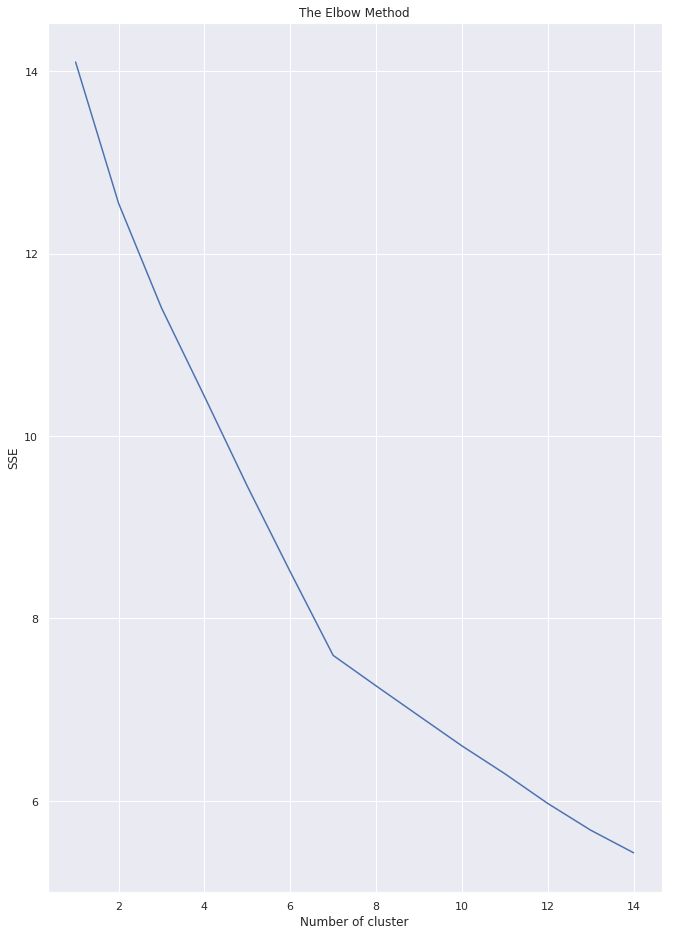

In [88]:
sse = {}
for k in range(1,15):
    kmeans = KMeans(n_clusters=k,random_state=0)
    kmeans.fit(bangalore_venues_grouped.drop('Neighborhood',axis=1))
    bangalore_venues_grouped['Cluster'] = kmeans.labels_
    sse[k] = kmeans.inertia_

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.title('The Elbow Method')
plt.show()

### From the above graph, we can see the optimal value for cluster is 5.

In [89]:
kmeans = KMeans(n_clusters=5,random_state=0)

In [90]:
kmeans.fit(bangalore_venues_grouped.drop('Neighborhood',axis=1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [91]:
bangalore_venues_grouped['Cluster'] = kmeans.labels_

In [92]:
bangalore_venues_grouped.groupby('Cluster')['Neighborhood'].count()

Cluster
0    24
1     3
2    18
3     5
4    12
Name: Neighborhood, dtype: int64

In [93]:
bangalore_venues_grouped.columns

Index(['Neighborhood', 'Venue Category_ATM',
       'Venue Category_Andhra Restaurant', 'Venue Category_Art Museum',
       'Venue Category_Arts & Crafts Store', 'Venue Category_Asian Restaurant',
       'Venue Category_Athletics & Sports', 'Venue Category_Auto Garage',
       'Venue Category_BBQ Joint', 'Venue Category_Badminton Court',
       ...
       'Venue Category_Tea Room', 'Venue Category_Tex-Mex Restaurant',
       'Venue Category_Toll Plaza', 'Venue Category_Train Station',
       'Venue Category_Udupi Restaurant',
       'Venue Category_Vegetarian / Vegan Restaurant',
       'Venue Category_Vietnamese Restaurant', 'Venue Category_Women's Store',
       'Venue Category_Yoga Studio', 'Cluster'],
      dtype='object', length=133)

In [94]:
neighborhoods_venues_sorted = neighborhoods_venues_sorted.merge(bangalore_venues_grouped,on='Neighborhood')

In [95]:
neighborhoods_venues_sorted.head(4)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,Venue Category_Tea Room,Venue Category_Tex-Mex Restaurant,Venue Category_Toll Plaza,Venue Category_Train Station,Venue Category_Udupi Restaurant,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Women's Store,Venue Category_Yoga Studio,Cluster
0,Anjanapura,Venue Category_ATM,Venue Category_Cosmetics Shop,Venue Category_Deli / Bodega,Venue Category_Department Store,Venue Category_Dessert Shop,Venue Category_Dim Sum Restaurant,Venue Category_Diner,Venue Category_Donut Shop,Venue Category_Eastern European Restaurant,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,4
1,Arekere,Venue Category_Indian Restaurant,Venue Category_Sporting Goods Shop,Venue Category_Department Store,Venue Category_Pizza Place,Venue Category_Breakfast Spot,Venue Category_Bar,Venue Category_Mughlai Restaurant,Venue Category_Chinese Restaurant,Venue Category_Fast Food Restaurant,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0
2,BTM Layout,Venue Category_Indian Restaurant,Venue Category_Ice Cream Shop,Venue Category_Snack Place,Venue Category_Bakery,Venue Category_Sandwich Place,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Coffee Shop,Venue Category_Pizza Place,Venue Category_Chinese Restaurant,...,0.0,0.0,0.0,0.0,0.0,0.055556,0.0,0.0,0.0,0
3,Banashankari,Venue Category_Clothing Store,Venue Category_Café,Venue Category_Breakfast Spot,Venue Category_North Indian Restaurant,Venue Category_Indian Restaurant,Venue Category_Fast Food Restaurant,Venue Category_Pizza Place,Venue Category_Motorcycle Shop,Venue Category_Electronics Store,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0


In [96]:
neighborhoods_venues_sorted.columns
neighborhoods_venues_sorted = neighborhoods_venues_sorted.merge(bangalore_venues,on='Neighborhood')

In [97]:
# create map
map_clusters = folium.Map(location=[bangalore_latitude, bangalore_longitude], zoom_start=11)

In [98]:
# set color scheme for the clusters
x = np.arange(6)
ys = [i + x + (i*x)**2 for i in range(6)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighborhoods_venues_sorted['Neighborhood Latitude'], neighborhoods_venues_sorted['Neighborhood Longitude'], neighborhoods_venues_sorted['Neighborhood'], neighborhoods_venues_sorted['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       

In [99]:
map_clusters

## Finding similar locations based on user input (recommending location)
#### We need to analyze factors such as population and Income to recommend.

In [100]:
bangalore_income.head()

,Borough,Neighborhoods,AverageIncome
0,Central,Cantonment area,18944.099792
1,Central,Domlur,56837.022198
2,Central,Indiranagar,41991.817435
3,Central,Jeevanbheemanagar,6667.447632
4,Central,Malleswaram,53270.063892


In [101]:
bangalore_population.head()

,Borough,Neighborhoods,Population
0,Central,Cantonment area,866377
1,Central,Domlur,743186
2,Central,Indiranagar,474289
3,Central,Jeevanbheemanagar,527874
4,Central,Malleswaram,893629


In [102]:
bangalore_population['Normalized_population'] = bangalore_population['Population']/bangalore_population['Population'].max(axis=0)
bangalore_population.head()

,Borough,Neighborhoods,Population,Normalized_population
0,Central,Cantonment area,866377,0.880810
1,Central,Domlur,743186,0.755567
2,Central,Indiranagar,474289,0.482190
3,Central,Jeevanbheemanagar,527874,0.536668
4,Central,Malleswaram,893629,0.908516


In [103]:
bangalore_income['Normalized_income'] = bangalore_income['AverageIncome']/bangalore_income['AverageIncome'].max(axis=0)
bangalore_income.head()

,Borough,Neighborhoods,AverageIncome,Normalized_income
0,Central,Cantonment area,18944.099792,0.293051
1,Central,Domlur,56837.022198,0.879225
2,Central,Indiranagar,41991.817435,0.649581
3,Central,Jeevanbheemanagar,6667.447632,0.103140
4,Central,Malleswaram,53270.063892,0.824047


In [104]:
bangalore_venues_grouped.head(1)

,Neighborhood,Venue Category_ATM,Venue Category_Andhra Restaurant,Venue Category_Art Museum,Venue Category_Arts & Crafts Store,Venue Category_Asian Restaurant,Venue Category_Athletics & Sports,Venue Category_Auto Garage,Venue Category_BBQ Joint,Venue Category_Badminton Court,...,Venue Category_Tea Room,Venue Category_Tex-Mex Restaurant,Venue Category_Toll Plaza,Venue Category_Train Station,Venue Category_Udupi Restaurant,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Women's Store,Venue Category_Yoga Studio,Cluster
0,Anjanapura,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


#### recommending Veg restaurants

In [105]:
bangalore_veg = bangalore_venues_onehot.groupby(['Neighborhood']).sum().reset_index()
bangalore_veg.head()

,Neighborhood,Venue Category_ATM,Venue Category_Andhra Restaurant,Venue Category_Art Museum,Venue Category_Arts & Crafts Store,Venue Category_Asian Restaurant,Venue Category_Athletics & Sports,Venue Category_Auto Garage,Venue Category_BBQ Joint,Venue Category_Badminton Court,...,Venue Category_Supermarket,Venue Category_Tea Room,Venue Category_Tex-Mex Restaurant,Venue Category_Toll Plaza,Venue Category_Train Station,Venue Category_Udupi Restaurant,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Women's Store,Venue Category_Yoga Studio
0,Anjanapura,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Arekere,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,BTM Layout,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
3,Banashankari,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Banaswadi,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [106]:
bangalore_veg['Venue Category_Vegetarian / Vegan Restaurant']

0     0
1     0
2     2
3     0
4     1
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    1
25    0
26    0
27    0
28    0
29    0
     ..
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
43    0
44    0
45    0
46    0
47    0
48    0
49    0
50    0
51    0
52    0
53    0
54    0
55    0
56    1
57    0
58    0
59    0
60    0
61    0
Name: Venue Category_Vegetarian / Vegan Restaurant, Length: 62, dtype: uint8

In [107]:
bangalore_veg = bangalore_veg[['Neighborhood','Venue Category_Vegetarian / Vegan Restaurant']]

In [108]:
bangalore_veg.rename(columns={'Venue Category_Vegetarian / Vegan Restaurant':'NumberOfVegRestaurants'},inplace=True)

In [109]:
bangalore_veg.head()

,Neighborhood,NumberOfVegRestaurants
0,Anjanapura,0
1,Arekere,0
2,BTM Layout,2
3,Banashankari,0
4,Banaswadi,1


In [110]:
bangalore_veg['NumberOfNonVeganrestaurants'] = 1-(bangalore_veg['NumberOfVegRestaurants']/bangalore_veg['NumberOfVegRestaurants'].max(axis=0))

In [111]:
bangalore_veg.head(10)

,Neighborhood,NumberOfVegRestaurants,NumberOfNonVeganrestaurants
0,Anjanapura,0,1.0
1,Arekere,0,1.0
2,BTM Layout,2,0.0
3,Banashankari,0,1.0
4,Banaswadi,1,0.5
5,Basavanagudi,0,1.0
6,Basaveshwaranagar,0,1.0
7,Begur,0,1.0
8,Bellandur,0,1.0
9,Bommanahalli,0,1.0


In [112]:
bangalore_veg.rename(columns={'Neighborhood':'Neighborhoods'},inplace=True)

### Building a target neighborhood by providing a sample restaurant : say ' Whitefield '

In [113]:
target_cluster_dataframe = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Neighborhood']=='Whitefield']

In [114]:
target_cluster_dataframe.reset_index()

,index,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,...,Venue Category_Women's Store,Venue Category_Yoga Studio,Cluster,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,587,Whitefield,Venue Category_Bakery,Venue Category_Eastern European Restaurant,Venue Category_Hotel Bar,Venue Category_Hotel,Venue Category_Café,Venue Category_Market,Venue Category_Kerala Restaurant,Venue Category_Gym / Fitness Center,...,0.0,0.0,4,Eastern,12.9698,77.7499,Herbs and Spices,12.968145,77.750862,Eastern European Restaurant
1,588,Whitefield,Venue Category_Bakery,Venue Category_Eastern European Restaurant,Venue Category_Hotel Bar,Venue Category_Hotel,Venue Category_Café,Venue Category_Market,Venue Category_Kerala Restaurant,Venue Category_Gym / Fitness Center,...,0.0,0.0,4,Eastern,12.9698,77.7499,Golds Gym,12.972217,77.750529,Gym / Fitness Center
2,589,Whitefield,Venue Category_Bakery,Venue Category_Eastern European Restaurant,Venue Category_Hotel Bar,Venue Category_Hotel,Venue Category_Café,Venue Category_Market,Venue Category_Kerala Restaurant,Venue Category_Gym / Fitness Center,...,0.0,0.0,4,Eastern,12.9698,77.7499,Chef Baker's,12.969730,77.751302,Bakery
3,590,Whitefield,Venue Category_Bakery,Venue Category_Eastern European Restaurant,Venue Category_Hotel Bar,Venue Category_Hotel,Venue Category_Café,Venue Category_Market,Venue Category_Kerala Restaurant,Venue Category_Gym / Fitness Center,...,0.0,0.0,4,Eastern,12.9698,77.7499,Royal Orchid Suites,12.966774,77.751262,Hotel
4,591,Whitefield,Venue Category_Bakery,Venue Category_Eastern European Restaurant,Venue Category_Hotel Bar,Venue Category_Hotel,Venue Category_Café,Venue Category_Market,Venue Category_Kerala Restaurant,Venue Category_Gym / Fitness Center,...,0.0,0.0,4,Eastern,12.9698,77.7499,The river side bar and kitchen,12.967298,77.749614,Hotel Bar
5,592,Whitefield,Venue Category_Bakery,Venue Category_Eastern European Restaurant,Venue Category_Hotel Bar,Venue Category_Hotel,Venue Category_Café,Venue Category_Market,Venue Category_Kerala Restaurant,Venue Category_Gym / Fitness Center,...,0.0,0.0,4,Eastern,12.9698,77.7499,Cheenavala,12.966435,77.749368,Kerala Restaurant
6,593,Whitefield,Venue Category_Bakery,Venue Category_Eastern European Restaurant,Venue Category_Hotel Bar,Venue Category_Hotel,Venue Category_Café,Venue Category_Market,Venue Category_Kerala Restaurant,Venue Category_Gym / Fitness Center,...,0.0,0.0,4,Eastern,12.9698,77.7499,Fabindia,12.972156,77.750447,Market
7,594,Whitefield,Venue Category_Bakery,Venue Category_Eastern European Restaurant,Venue Category_Hotel Bar,Venue Category_Hotel,Venue Category_Café,Venue Category_Market,Venue Category_Kerala Restaurant,Venue Category_Gym / Fitness Center,...,0.0,0.0,4,Eastern,12.9698,77.7499,refresh,12.965621,77.749234,Café


In [115]:
target_cluster = target_cluster_dataframe.iloc[0].at['Cluster']

In [116]:
target_cluster

4

In [117]:
print("The target cluster is : ",target_cluster)

The target cluster is :  4


In [118]:
possible_neighborhoods = neighborhoods_venues_sorted[neighborhoods_venues_sorted['Cluster']==target_cluster]
possible_neighborhoods.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,Venue Category_Women's Store,Venue Category_Yoga Studio,Cluster,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Anjanapura,Venue Category_ATM,Venue Category_Cosmetics Shop,Venue Category_Deli / Bodega,Venue Category_Department Store,Venue Category_Dessert Shop,Venue Category_Dim Sum Restaurant,Venue Category_Diner,Venue Category_Donut Shop,Venue Category_Eastern European Restaurant,...,0.0,0.0,4,SouthernSuburbs,12.860400,77.561200,State Bank of India ATM,12.861650,77.561634,ATM
174,Electronic City,Venue Category_Outlet Store,Venue Category_Furniture / Home Store,Venue Category_Bus Stop,Venue Category_Toll Plaza,Venue Category_Auto Garage,Venue Category_Eastern European Restaurant,Venue Category_Fish & Chips Shop,Venue Category_Fast Food Restaurant,Venue Category_Falafel Restaurant,...,0.0,0.0,4,SouthEastern,12.840711,77.676369,e-Toll Gate,12.842121,77.675325,Toll Plaza
175,Electronic City,Venue Category_Outlet Store,Venue Category_Furniture / Home Store,Venue Category_Bus Stop,Venue Category_Toll Plaza,Venue Category_Auto Garage,Venue Category_Eastern European Restaurant,Venue Category_Fish & Chips Shop,Venue Category_Fast Food Restaurant,Venue Category_Falafel Restaurant,...,0.0,0.0,4,SouthEastern,12.840711,77.676369,Global Living Emporio,12.841080,77.675598,Furniture / Home Store
176,Electronic City,Venue Category_Outlet Store,Venue Category_Furniture / Home Store,Venue Category_Bus Stop,Venue Category_Toll Plaza,Venue Category_Auto Garage,Venue Category_Eastern European Restaurant,Venue Category_Fish & Chips Shop,Venue Category_Fast Food Restaurant,Venue Category_Falafel Restaurant,...,0.0,0.0,4,SouthEastern,12.840711,77.676369,Huskur Gate,12.839797,77.677198,Bus Stop
177,Electronic City,Venue Category_Outlet Store,Venue Category_Furniture / Home Store,Venue Category_Bus Stop,Venue Category_Toll Plaza,Venue Category_Auto Garage,Venue Category_Eastern European Restaurant,Venue Category_Fish & Chips Shop,Venue Category_Fast Food Restaurant,Venue Category_Falafel Restaurant,...,0.0,0.0,4,SouthEastern,12.840711,77.676369,Audi Bengaluru Service,12.842437,77.675649,Auto Garage


In [119]:
print("There are {} neighborhoods which has similar characteristics to Whitefield.".format(possible_neighborhoods.shape[0]))

There are 130 neighborhoods which has similar characteristics to Whitefield.


In [120]:
possible_neighborhoods.reset_index().head()

,index,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,...,Venue Category_Women's Store,Venue Category_Yoga Studio,Cluster,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Anjanapura,Venue Category_ATM,Venue Category_Cosmetics Shop,Venue Category_Deli / Bodega,Venue Category_Department Store,Venue Category_Dessert Shop,Venue Category_Dim Sum Restaurant,Venue Category_Diner,Venue Category_Donut Shop,...,0.0,0.0,4,SouthernSuburbs,12.860400,77.561200,State Bank of India ATM,12.861650,77.561634,ATM
1,174,Electronic City,Venue Category_Outlet Store,Venue Category_Furniture / Home Store,Venue Category_Bus Stop,Venue Category_Toll Plaza,Venue Category_Auto Garage,Venue Category_Eastern European Restaurant,Venue Category_Fish & Chips Shop,Venue Category_Fast Food Restaurant,...,0.0,0.0,4,SouthEastern,12.840711,77.676369,e-Toll Gate,12.842121,77.675325,Toll Plaza
2,175,Electronic City,Venue Category_Outlet Store,Venue Category_Furniture / Home Store,Venue Category_Bus Stop,Venue Category_Toll Plaza,Venue Category_Auto Garage,Venue Category_Eastern European Restaurant,Venue Category_Fish & Chips Shop,Venue Category_Fast Food Restaurant,...,0.0,0.0,4,SouthEastern,12.840711,77.676369,Global Living Emporio,12.841080,77.675598,Furniture / Home Store
3,176,Electronic City,Venue Category_Outlet Store,Venue Category_Furniture / Home Store,Venue Category_Bus Stop,Venue Category_Toll Plaza,Venue Category_Auto Garage,Venue Category_Eastern European Restaurant,Venue Category_Fish & Chips Shop,Venue Category_Fast Food Restaurant,...,0.0,0.0,4,SouthEastern,12.840711,77.676369,Huskur Gate,12.839797,77.677198,Bus Stop
4,177,Electronic City,Venue Category_Outlet Store,Venue Category_Furniture / Home Store,Venue Category_Bus Stop,Venue Category_Toll Plaza,Venue Category_Auto Garage,Venue Category_Eastern European Restaurant,Venue Category_Fish & Chips Shop,Venue Category_Fast Food Restaurant,...,0.0,0.0,4,SouthEastern,12.840711,77.676369,Audi Bengaluru Service,12.842437,77.675649,Auto Garage


In [121]:
possible_neighborhoods.rename(columns={'Neighborhood':'Neighborhoods'},inplace=True)

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


### Now we need to create ranking by combining population and income factors as well?

In [122]:
possible_neighborhoods = possible_neighborhoods.merge(bangalore_population[['Neighborhoods','Population','Normalized_population']],on='Neighborhoods')
possible_neighborhoods = possible_neighborhoods.merge(bangalore_income[['Neighborhoods','AverageIncome','Normalized_income']],on='Neighborhoods')
possible_neighborhoods = possible_neighborhoods.merge(bangalore_veg[['Neighborhoods','NumberOfVegRestaurants','NumberOfNonVeganrestaurants']],on='Neighborhoods')

In [123]:
possible_neighborhoods.head()

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,Venue,Venue Latitude,Venue Longitude,Venue Category,Population,Normalized_population,AverageIncome,Normalized_income,NumberOfVegRestaurants,NumberOfNonVeganrestaurants
0,Anjanapura,Venue Category_ATM,Venue Category_Cosmetics Shop,Venue Category_Deli / Bodega,Venue Category_Department Store,Venue Category_Dessert Shop,Venue Category_Dim Sum Restaurant,Venue Category_Diner,Venue Category_Donut Shop,Venue Category_Eastern European Restaurant,...,State Bank of India ATM,12.861650,77.561634,ATM,940039,0.955699,44218.922553,0.684032,0,1.0
1,Electronic City,Venue Category_Outlet Store,Venue Category_Furniture / Home Store,Venue Category_Bus Stop,Venue Category_Toll Plaza,Venue Category_Auto Garage,Venue Category_Eastern European Restaurant,Venue Category_Fish & Chips Shop,Venue Category_Fast Food Restaurant,Venue Category_Falafel Restaurant,...,e-Toll Gate,12.842121,77.675325,Toll Plaza,781260,0.794275,8350.934536,0.129182,0,1.0
2,Electronic City,Venue Category_Outlet Store,Venue Category_Furniture / Home Store,Venue Category_Bus Stop,Venue Category_Toll Plaza,Venue Category_Auto Garage,Venue Category_Eastern European Restaurant,Venue Category_Fish & Chips Shop,Venue Category_Fast Food Restaurant,Venue Category_Falafel Restaurant,...,Global Living Emporio,12.841080,77.675598,Furniture / Home Store,781260,0.794275,8350.934536,0.129182,0,1.0
3,Electronic City,Venue Category_Outlet Store,Venue Category_Furniture / Home Store,Venue Category_Bus Stop,Venue Category_Toll Plaza,Venue Category_Auto Garage,Venue Category_Eastern European Restaurant,Venue Category_Fish & Chips Shop,Venue Category_Fast Food Restaurant,Venue Category_Falafel Restaurant,...,Huskur Gate,12.839797,77.677198,Bus Stop,781260,0.794275,8350.934536,0.129182,0,1.0
4,Electronic City,Venue Category_Outlet Store,Venue Category_Furniture / Home Store,Venue Category_Bus Stop,Venue Category_Toll Plaza,Venue Category_Auto Garage,Venue Category_Eastern European Restaurant,Venue Category_Fish & Chips Shop,Venue Category_Fast Food Restaurant,Venue Category_Falafel Restaurant,...,Audi Bengaluru Service,12.842437,77.675649,Auto Garage,781260,0.794275,8350.934536,0.129182,0,1.0


In [124]:
possible_neighborhoods['Ranking'] = possible_neighborhoods['Normalized_population'] * 0.5 + possible_neighborhoods['Normalized_income'] * 0.35 + possible_neighborhoods['NumberOfNonVeganrestaurants'] * 0.1
recommended_neighborhoods = possible_neighborhoods.sort_values(by='Ranking',ascending=False)
recommended_neighborhoods.reset_index(inplace=True, drop=True)

In [125]:
recommended_neighborhoods.head()

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,Venue Latitude,Venue Longitude,Venue Category,Population,Normalized_population,AverageIncome,Normalized_income,NumberOfVegRestaurants,NumberOfNonVeganrestaurants,Ranking
0,Anjanapura,Venue Category_ATM,Venue Category_Cosmetics Shop,Venue Category_Deli / Bodega,Venue Category_Department Store,Venue Category_Dessert Shop,Venue Category_Dim Sum Restaurant,Venue Category_Diner,Venue Category_Donut Shop,Venue Category_Eastern European Restaurant,...,12.861650,77.561634,ATM,940039,0.955699,44218.922553,0.684032,0,1.0,0.817261
1,Kumaraswamy Layout,Venue Category_Sandwich Place,Venue Category_Bakery,Venue Category_Food Truck,Venue Category_Burger Joint,Venue Category_Breakfast Spot,Venue Category_Market,Venue Category_Café,Venue Category_Chinese Restaurant,Venue Category_Fast Food Restaurant,...,12.899702,77.560684,Market,983614,1.000000,10941.420381,0.169255,0,1.0,0.659239
2,Kumaraswamy Layout,Venue Category_Sandwich Place,Venue Category_Bakery,Venue Category_Food Truck,Venue Category_Burger Joint,Venue Category_Breakfast Spot,Venue Category_Market,Venue Category_Café,Venue Category_Chinese Restaurant,Venue Category_Fast Food Restaurant,...,12.906870,77.563343,Burger Joint,983614,1.000000,10941.420381,0.169255,0,1.0,0.659239
3,Kumaraswamy Layout,Venue Category_Sandwich Place,Venue Category_Bakery,Venue Category_Food Truck,Venue Category_Burger Joint,Venue Category_Breakfast Spot,Venue Category_Market,Venue Category_Café,Venue Category_Chinese Restaurant,Venue Category_Fast Food Restaurant,...,12.905313,77.562773,Breakfast Spot,983614,1.000000,10941.420381,0.169255,0,1.0,0.659239
4,Kumaraswamy Layout,Venue Category_Sandwich Place,Venue Category_Bakery,Venue Category_Food Truck,Venue Category_Burger Joint,Venue Category_Breakfast Spot,Venue Category_Market,Venue Category_Café,Venue Category_Chinese Restaurant,Venue Category_Fast Food Restaurant,...,12.903011,77.560215,Chinese Restaurant,983614,1.000000,10941.420381,0.169255,0,1.0,0.659239


In [126]:
top3 = recommended_neighborhoods.groupby(['Neighborhoods','1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue'])['Ranking'].unique()

In [127]:
top3_df = pd.DataFrame(top3).reset_index()

In [128]:
top3_df.head(3)

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Ranking
0,Anjanapura,Venue Category_ATM,Venue Category_Cosmetics Shop,Venue Category_Deli / Bodega,[0.8172608992676407]
1,Electronic City,Venue Category_Outlet Store,Venue Category_Furniture / Home Store,Venue Category_Bus Stop,[0.5423513638809381]
2,Indiranagar,Venue Category_Pub,Venue Category_Lounge,Venue Category_Café,[0.5684483844100865]


#### Here, according the data, we see that 'Begur,Hulimavu and kamakshipalya' are top 3 neighborhoods to find similar food to whitefield restaurant's veg food !
#### Here our model will recommend these neighborneeds and top 3 common venues to visit.

# Thank you for reviewing !